## Titanic Survivorship, Logistic Regression & SVM Classification

This notebook performs a simple logistic regression and a SVM classification on the data from the Kaggle project on predicting survivorship of the passengers of the Titanic.  Not much is done in feature engineering beyond replacing missing values with medians. We grade the results by using the full survivorship data that was downloaded from [Vanderbuilt Biostats](http://biostat.mc.vanderbilt.edu/wiki/Main/DataSets) from the file titanic3.csv

It is important that the column names between these various csv's match and that the passenger names match as well so that we can perform table merges correctly.  The Kaggle data has capitalized column names while the Vanderbuilt does not, so I modified titanic3.csv so that, where appropriate, the column names match.

Also, these two data sources treat embedded double quotes differently.  The Vanderbuilt data is consistent, but the Kaggle date is really borked on this one.  So I removed all embedded double quotes from the files.  This can be done by the following shell commands.

    sed -e 's/\"\"\"\"\"/\"/g' -e 's/\"\"\"/\"/g' -e 's/\"\"//g' train.csv >train_mod.csv
    sed -e 's/\"\"\"\"\"/\"/g' -e 's/\"\"\"/\"/g' -e 's/\"\"//g' test.csv >test_mod.csv

Now for the code.  First the imports and a define of a custom exception

In [18]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import sklearn
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression

class PredictionError(Exception):
    pass

We will read in the data (eventually) using the pandas read_csv method.  I chose to read all of it in and clean it in a separate step.  That is done by this function, which is largely what the Kaggle Python code does (only a little less ugly)

In [19]:
def clean_data(tdf):
    tdf['gender'] = tdf['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

    # Missing values will be filled with medians
    tdf = tdf.fillna(tdf.median())

    # Drop all the features that will not be used in logistic regression
    tdf = tdf.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'PassengerId',
                    'Embarked'], axis=1)
    return tdf

We would like to find out how accurate our predictions are and since we have the full survivorship data in titanic3.csv (or titanic3_mod.csv) we can do that.  Here we assume that we have a DataFrame that has the ground truth column as well as the prediction column.  We pass in the dataframe, the name of the ground truth column and the prediction column.

In [20]:
def score_results(df, gt, pred):
    """ Score the results in a DataFrame that has both the ground
        truth and the prediction. gt is the name of the ground truth
        column etc.  Return the raw accuracy, the precision and the recall.
        Note that precision and recall are most useful for evaluating
        predictions on rare events. """
    correct = df.ix[df[gt] == df[pred]]
    incorrect = df.ix[df[gt] != df[pred]]
    true_pos = len(correct.ix[correct[gt] == 1])
    true_neg = len(correct.ix[correct[gt] == 0])
    false_neg = len(incorrect.ix[incorrect[pred] == 0])
    false_pos = len(incorrect.ix[incorrect[pred] == 1])

    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    num_correct = len(correct)
    tot_pred = len(df)
    accuracy = num_correct / tot_pred
    return accuracy, precision, recall

Now we can read in the data, clean it, and before doing any training, we take a look at the correlation coefficients of the data. Not surprisingly, there is a wide range of correlation.

In [21]:
trdf = pd.read_csv("train_mod.csv", header=0)
trdf = clean_data(trdf)
#print(trdf.describe())
print(trdf.corr())

          Survived    Pclass       Age     SibSp     Parch      Fare    gender
Survived  1.000000 -0.338481 -0.064910 -0.035322  0.081629  0.257307 -0.543351
Pclass   -0.338481  1.000000 -0.339898  0.083081  0.018443 -0.549500  0.131900
Age      -0.064910 -0.339898  1.000000 -0.233296 -0.172482  0.096688  0.081163
SibSp    -0.035322  0.083081 -0.233296  1.000000  0.414838  0.159651 -0.114631
Parch     0.081629  0.018443 -0.172482  0.414838  1.000000  0.216225 -0.245489
Fare      0.257307 -0.549500  0.096688  0.159651  0.216225  1.000000 -0.182333
gender   -0.543351  0.131900  0.081163 -0.114631 -0.245489 -0.182333  1.000000


So the pairwise correlation for **Survived** is high for **Pclass**, **Fare**, and **gender**, but much smaller for the others.  Now we are ready to train a Logistic and see how well it performs

In [22]:
train = trdf.values
logit = LogisticRegression()
logit.fit(train[:, 1:], train[:, 0])

testdf = pd.read_csv("test_mod.csv", header=0)
pass_survival = testdf.copy()
svm_test = testdf.copy()        # for later use with an svm classifier
testdf = clean_data(testdf)

c = logit.predict(testdf.values)

# add the survival prediction column
pass_survival['pred_survival'] = c

# Get the ground truth dataset
gtdf = pd.read_csv("titanic3_mod.csv", header=0)

# Now merge the predictions with the ground truth.  This
# is like a table join in the database world.
ansdf = pd.merge(gtdf, pass_survival)

# check to see if we got all the answers
if len(pass_survival) != len(ansdf):
    raise PredictionError("Did not match all predictions with ground truth")

accuracy, precision, recall = score_results(ansdf, 'Survived', 
                                                'pred_survival')

print("accuracy: {}   precision: {}   recall: {}".format(accuracy,
           precision, recall))

accuracy: 0.7655502392344498   precision: 0.6973684210526315   recall: 0.6708860759493671


So a 76.5% accuracy using 6 features (Pclass, Age, SibSp, Parch, Fare, Gender) and recall that all missing values were replaced by means.

We forgot to see how well this model does on the training data itself.  Let's take a look

In [23]:
m = logit.predict(train[:, 1:])
m_surv = trdf.copy()
m_surv['pred_survival'] = m

moddf = pd.merge(gtdf, m_surv)
a, p, r = score_results(moddf, 'Survived', 'pred_survival')
print("accuracy: {}   precision: {}   recall: {}".format(a, p, r))

accuracy: 0.8183738120380147   precision: 0.7681660899653979   recall: 0.6788990825688074


So we do get the expected results that the model performs better on the training data than on the test data.  But it is not that much better.  This shows that whoever did the data partitioning, did a reasonibly good (or random) job.

The data we fit used 6 different features.  If we want to visualize this we can reduce the dimensionality to 2 and plot to see if there is any clustering.  We will use the tSNE algorithm that is described [here](https://beta.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm) and we use the training data set. Note that the survival data is **not** used in the t-SNE algorithm, but we do use it to color the dots in the scatter plot to help visualization.

(-24.608657092592388,
 30.924201856732687,
 -27.817194373451549,
 31.951642676998187)

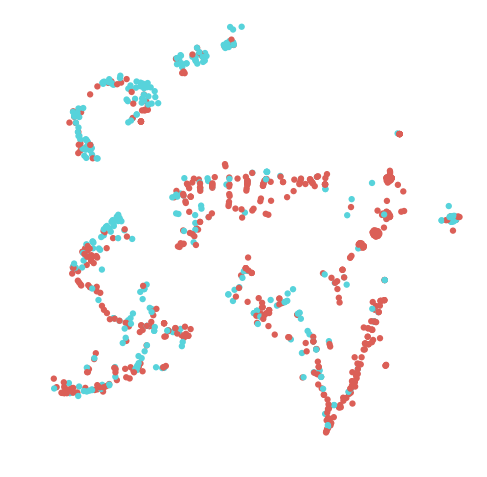

In [24]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", rc={"lines.linewidth": 2.5})

palette = np.array(sns.color_palette("hls", 2))

# We want the same visualization so we set random seed
x = TSNE(random_state=14921137).fit_transform(train[:, 1:])

f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(x[:,0], x[:,1], lw=0,  s=40, c=palette[train[:, 0].astype(np.int)])
plt.xlim(-25, 25)
plt.ylim(-25, 25)
ax.axis('off')
ax.axis('tight')

It certainly looks like there is some clustering of the data. Unfortunately for us, this clustering doesn't seem to distinguish much between those who survived and those who did not.  This makes me suspect that using an SVM classifier will have poor results.  Let's see if that is true.  Given this picture, I am not going to bother with a linear classifier but instead go straight to a non-linear one.

In [25]:
cla = sklearn.svm.NuSVC()
cla.fit(train[:, 1:], train[:, 0])
svm_results = cla.predict(testdf.values)
svm_test['pred_survival'] = svm_results
#print(svm_test.describe())

svm_ansdf = pd.merge(gtdf, svm_test)
#print(svm_ansdf.describe())

# check to see if we got all the answers
if len(svm_test) != len(svm_ansdf):
    raise PredictionError("Did not match all predictions with ground truth")

accuracy, precision, recall = score_results(svm_ansdf, 'Survived', 
                                                'pred_survival')

print("accuracy: {}   precision: {}   recall: {}".format(accuracy,
           precision, recall))

accuracy: 0.6339712918660287   precision: 0.5151515151515151   recall: 0.5379746835443038


Ouch!  That didn't work too well.